In [1]:
from transformers import (
    HubertModel,
    HubertForSequenceClassification,
    Wav2Vec2FeatureExtractor,
    HubertPreTrainedModel,
)

import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


sns.set()

In [2]:
class CustomHubertModel(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.config = config
        self.hubert = HubertModel(config)

        self.fc1 = nn.Linear(config.hidden_size, 256)
        # self.fc2 = nn.Linear(256, 2)

        self.post_init()

    def forward(
            self,
            input_values,
            attention_mask=None,
            mask_time_indices=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = True if self.config.use_weighted_layer_sum else output_hidden_states

        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        relu = nn.ReLU(inplace=True)

        hidden_state = outputs.last_hidden_state
        hidden_state = self.fc1(hidden_state.mean(dim=1))
        hidden_state = relu(hidden_state)
        # embeddings = self.fc2(hidden_state)
        embeddings = hidden_state

        return {
            "embeddings": embeddings,
            "last_hidden_state": outputs.last_hidden_state
        }


In [3]:
def color_map_color(value, cmap_name='viridis', vmin=0, vmax=1):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.colormaps[cmap_name]
    rgb = cmap(norm(abs(value)))[:3]
    color = mcolors.rgb2hex(rgb)
    return color


def get_patches(colormap='viridis'):
    pathches = [
        # mpatches.Patch(color=color_map_color(0, colormap, 0, 3), label='neutral'),
        # mpatches.Patch(color=color_map_color(1, colormap, 0, 3), label='angry'),
        # mpatches.Patch(color=color_map_color(2, colormap, 0, 3), label='positive'),
        # mpatches.Patch(color=color_map_color(3, colormap, 0, 3), label='sad'),
        mpatches.Patch(color=color_map_color(0, colormap, 0, 1), label='positive'),
        mpatches.Patch(color=color_map_color(1, colormap, 0, 1), label='sad'),
    ]

    return pathches

def plot_2d(data, labels, title=""):
    reducer = PCA(n_components=2)
    # reducer = umap.UMAP()
    # reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)

    reduced_data = reducer.fit_transform(data)

    fig, ax = plt.subplots()
    ax.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], c=labels, cmap='viridis')

    ax.legend(handles=get_patches())
    ax.set_title(title)

    plt.show()

def plot_3d(data, labels, title=""):
    pca_3d = PCA(n_components=3)
    pca_3d_data = pca_3d.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(xs=pca_3d_data[:, 0], ys=pca_3d_data[:, 1], zs=pca_3d_data[:, 2], c=labels, cmap='viridis')
    ax.legend(handles=get_patches())
    ax.set_title(title)

    plt.show()

def plot_2d_triple(data, labels):
    reducers = [
        PCA(n_components=2),
        umap.UMAP(),
        TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
    ]

    titles = ["PCA", "UMAP", "TSNE"]

    fig, ax = plt.subplots(1, 3)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    for i in range(len(reducers)):
        reduced_data = reducers[i].fit_transform(data)
        ax[i].scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], c=labels, cmap='viridis')
        ax[i].legend(handles=get_patches())
        ax[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [4]:
def get_output_for_audio(audio, feature_extractor, model, sampling_rate=16000):
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]

    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)

    return output

def get_last_hidden_state_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output["last_hidden_state"].detach().numpy()[0]

    features_list = [hidden_state]
    labels_list = [[df['label'][0] for _ in range(hidden_state.shape[0])]]

    for index, row in df.iterrows():
        if (index == 0):
            continue

        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output["last_hidden_state"].detach().numpy()[0]

        features_list.append(hidden_state)
        labels_list.append([row['label'] for _ in range(hidden_state.shape[0])])

    data = np.concatenate(features_list)
    labels = np.concatenate(labels_list)

    return data, labels

def get_embeddings_and_labels(df, model, feature_extractor, sampling_rate=16000, embed_name="embeddings"):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output[embed_name].detach().numpy()[0]

    features_list = [[hidden_state]]
    labels_list = [df['label'][0]]

    for index, row in df.iterrows():
        if (index == 0):
            continue

        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output[embed_name].detach().numpy()[0]

        features_list.append([hidden_state])
        labels_list.append(row['label'])

    data = np.concatenate(features_list)
    labels = np.array(labels_list)

    return data, labels

In [6]:
model_id = "models/custom-hubert-base-dusha-ft-triplets-bin-3000"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model = CustomHubertModel.from_pretrained(
    model_id,
    local_files_only=True,
)
# labels_names = ["neutral", "angry", "positive", "sad"]
labels_names = ["positive", "sad"]
sampling_rate = feature_extractor.sampling_rate

In [7]:
# train_df = pd.read_csv("../data/triplets_480_train.csv")
# train_df = pd.read_csv("../data/triplets_bin_2000_train.csv")
# val_df = pd.read_csv("../data/triplets_bin_2000_val.csv")
train_df = pd.read_csv("../data/crowd_train_bin_500.csv")
test_df = pd.read_csv("../data/crowd_test_bin_500.csv")

In [8]:
# anchor_df = train_df[['anchor', 'anchor_label']].rename(columns={'anchor': 'audio_path', 'anchor_label': 'label'}).drop_duplicates()
# positive_df = train_df[['positive', 'positive_label']].rename(columns={'positive': 'audio_path', 'positive_label': 'label'}).drop_duplicates()
# negative_df = train_df[['negative', 'negative_label']].rename(columns={'negative': 'audio_path', 'negative_label': 'label'}).drop_duplicates()

# train_df = pd.concat([anchor_df, positive_df, negative_df], axis=0).drop_duplicates()
# train_df

In [9]:
# anchor_df = val_df[['anchor', 'anchor_label']].rename(columns={'anchor': 'audio_path', 'anchor_label': 'label'}).drop_duplicates()
# positive_df = val_df[['positive', 'positive_label']].rename(columns={'positive': 'audio_path', 'positive_label': 'label'}).drop_duplicates()
# negative_df = val_df[['negative', 'negative_label']].rename(columns={'negative': 'audio_path', 'negative_label': 'label'}).drop_duplicates()

# val_df = pd.concat([anchor_df, positive_df, negative_df], axis=0).drop_duplicates()
# val_df

In [10]:
test_df

,id,audio_path,features_path,emotion,label,duration
0,64a7aa17132c3e4b7be1aaed5fc88090,dusha/crowd/crowd_test/wavs/64a7aa17132c3e4b7b...,dusha/features/64a7aa17132c3e4b7be1aaed5fc8809...,positive,2,5.060000
1,33152583dcbf1fe40d142954a2a7ca23,dusha/crowd/crowd_test/wavs/33152583dcbf1fe40d...,dusha/features/33152583dcbf1fe40d142954a2a7ca2...,positive,2,7.600000
2,edde29c071343653eced8877747ed54b,dusha/crowd/crowd_test/wavs/edde29c071343653ec...,dusha/features/edde29c071343653eced8877747ed54...,positive,2,5.720000
3,952113a7bb4f28a9de885187dd0fe90e,dusha/crowd/crowd_test/wavs/952113a7bb4f28a9de...,dusha/features/952113a7bb4f28a9de885187dd0fe90...,positive,2,5.240000
4,083486716bff8bcad5a72de4de4f2ba9,dusha/crowd/crowd_test/wavs/083486716bff8bcad5...,dusha/features/083486716bff8bcad5a72de4de4f2ba...,positive,2,4.120000
...,...,...,...,...,...,...
995,ab09ff1c06271fc62f670fe69c12cc50,dusha/crowd/crowd_test/wavs/ab09ff1c06271fc62f...,dusha/features/ab09ff1c06271fc62f670fe69c12cc5...,sad,3,4.620000
996,e2f66e2722c15bc0ff6fd540a7cdf3f9,dusha/crowd/crowd_test/wavs/e2f66e2722c15bc0ff...,dusha/features/e2f66e2722c15bc0ff6fd540a7cdf3f...,sad,3,3.260000
997,372542365a52864d5047e6390cc246b3,dusha/crowd/crowd_test/wavs/372542365a52864d50...,dusha/features/372542365a52864d5047e6390cc246b...,sad,3,3.178313
998,d6f818cbc0d56b053893dc5ce116d246,dusha/crowd/crowd_test/wavs/d6f818cbc0d56b0538...,dusha/features/d6f818cbc0d56b053893dc5ce116d24...,sad,3,2.135813


In [13]:
train_df

,id,audio_path,features_path,emotion,label,duration
0,7b78ca15946bddcf4c02843f9c5bda17,dusha/crowd/crowd_train/wavs/7b78ca15946bddcf4...,dusha/features/7b78ca15946bddcf4c02843f9c5bda1...,sad,3,4.840000
1,ed5a0505897b5fd7fdd36e75e336e746,dusha/crowd/crowd_train/wavs/ed5a0505897b5fd7f...,dusha/features/ed5a0505897b5fd7fdd36e75e336e74...,positive,2,5.260000
2,347885402c51771785fad1b868b8a484,dusha/crowd/crowd_train/wavs/347885402c5177178...,dusha/features/347885402c51771785fad1b868b8a48...,positive,2,5.180000
3,bb83b6d620f8b47a3fc3d58ed4e55106,dusha/crowd/crowd_train/wavs/bb83b6d620f8b47a3...,dusha/features/bb83b6d620f8b47a3fc3d58ed4e5510...,positive,2,2.410312
4,e9a89b982685050c9a7d91ffb2e7ca23,dusha/crowd/crowd_train/wavs/e9a89b982685050c9...,dusha/features/e9a89b982685050c9a7d91ffb2e7ca2...,positive,2,3.340000
...,...,...,...,...,...,...
995,e6c522ab70e6e4902ee5c5e0345a8ab0,dusha/crowd/crowd_train/wavs/e6c522ab70e6e4902...,dusha/features/e6c522ab70e6e4902ee5c5e0345a8ab...,sad,3,4.480000
996,68bbabc12dc43cb7f629239175c75dc6,dusha/crowd/crowd_train/wavs/68bbabc12dc43cb7f...,dusha/features/68bbabc12dc43cb7f629239175c75dc...,sad,3,8.280000
997,41fd84b48da86acc41c4c06ed1dca057,dusha/crowd/crowd_train/wavs/41fd84b48da86acc4...,dusha/features/41fd84b48da86acc41c4c06ed1dca05...,sad,3,5.572375
998,956ba1f4f2a1da12b8b6678fe7f7e1de,dusha/crowd/crowd_train/wavs/956ba1f4f2a1da12b...,dusha/features/956ba1f4f2a1da12b8b6678fe7f7e1d...,sad,3,2.773000


## Обучение на двух класса эмоций

### Выход триплетной модели

In [ ]:
# n_samples = 150
# df_reduce = train_df.groupby(['label']).head(n_samples).reset_index(drop=True)

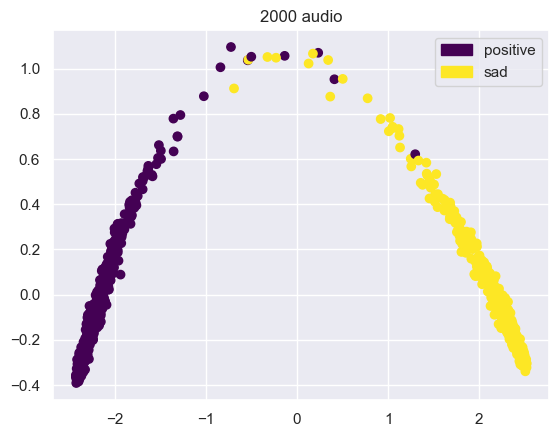

In [11]:
n_samples = 1000
data, labels = get_embeddings_and_labels(train_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples} audio")

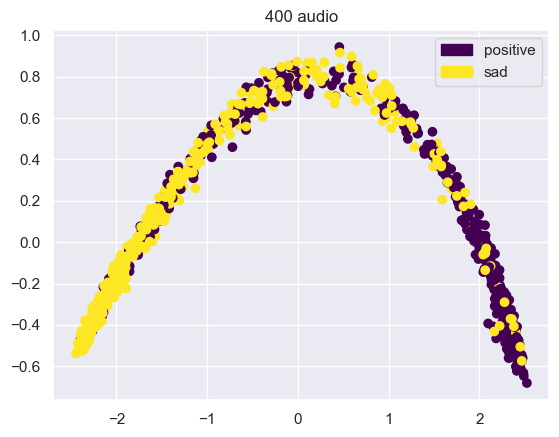

In [14]:
n_samples = 200
df_reduce = test_df.groupby(['label']).head(n_samples).reset_index(drop=True)
data, labels = get_embeddings_and_labels(test_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

## Модель без relu

### Тренировочный набор

In [14]:
n_samples = 150
df_reduce = train_df.groupby(['label']).head(n_samples).reset_index(drop=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


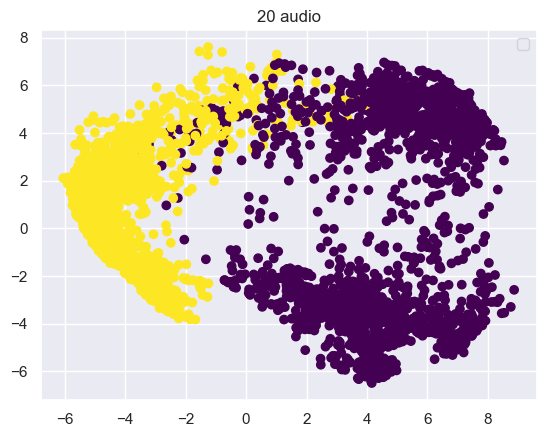

In [13]:
# custom-hubert-base-dusha-ft-triplets-bin-1500-no-relu
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


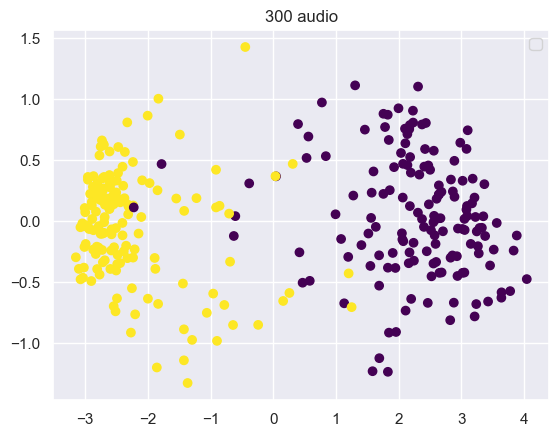

In [15]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

### Тестовый набор

In [17]:
bin_test = test_df.loc[(test_df["emotion"] == 'positive') | (test_df["emotion"] == 'sad')]

In [20]:
n_samples = 150
df_reduce = bin_test.groupby(['emotion']).head(n_samples).reset_index(drop=True)

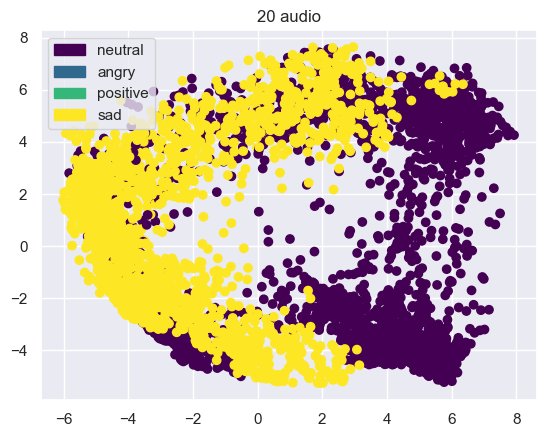

In [19]:
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

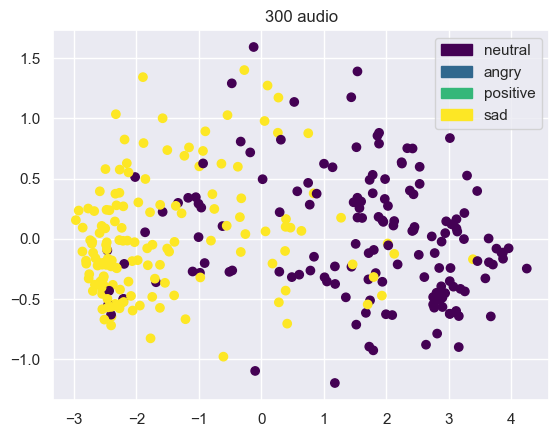

In [21]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

## Модель с relu

### Тренировочный набор

In [11]:
n_samples = 150
df_reduce = train_df.groupby(['label']).head(n_samples).reset_index(drop=True)

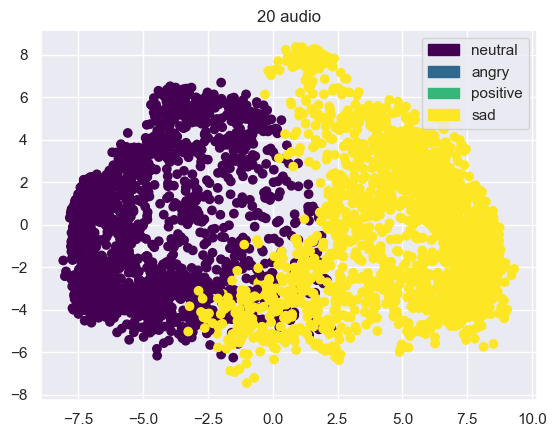

In [10]:
# custom-hubert-base-dusha-ft-triplets-bin-2000
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

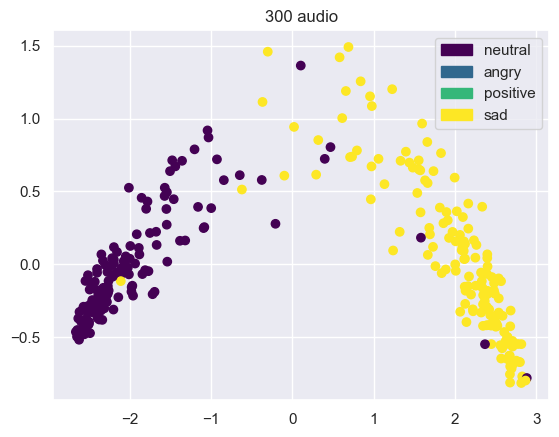

In [12]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

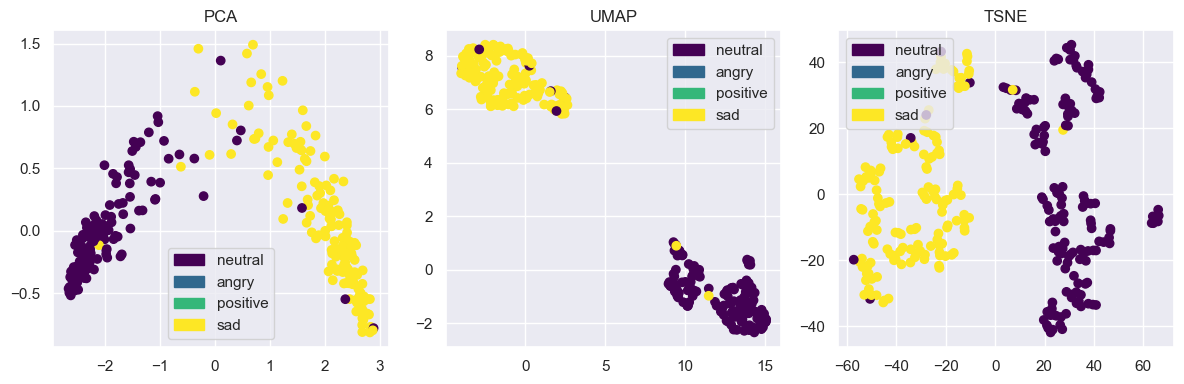

In [13]:
plot_2d_triple(data, labels)

### Валидационный набор

In [16]:
n_samples = 150
df_reduce = val_df.groupby(['label']).head(n_samples).reset_index(drop=True)

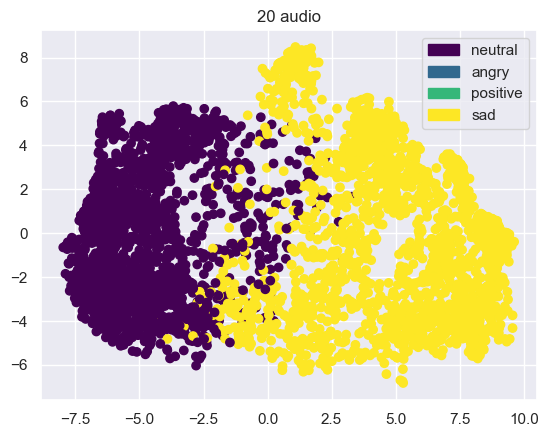

In [15]:
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

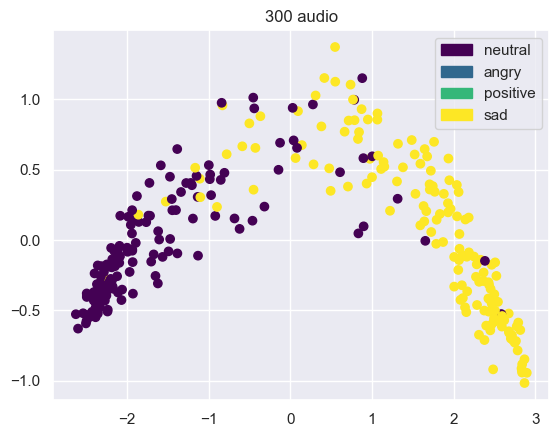

In [17]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

### Тестовый набор

In [18]:
bin_test = test_df.loc[(test_df["emotion"] == 'positive') | (test_df["emotion"] == 'sad')]

In [21]:
n_samples = 150
df_reduce = bin_test.groupby(['emotion']).head(n_samples).reset_index(drop=True)

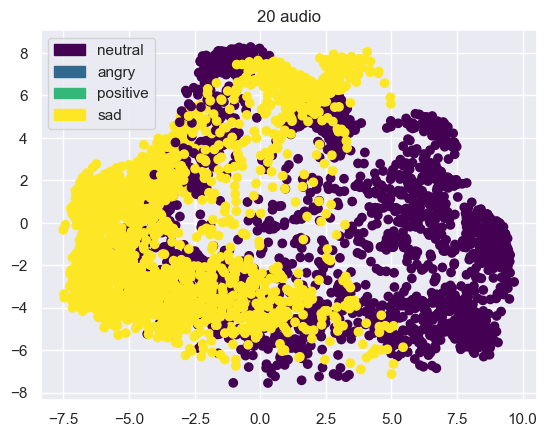

In [20]:
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

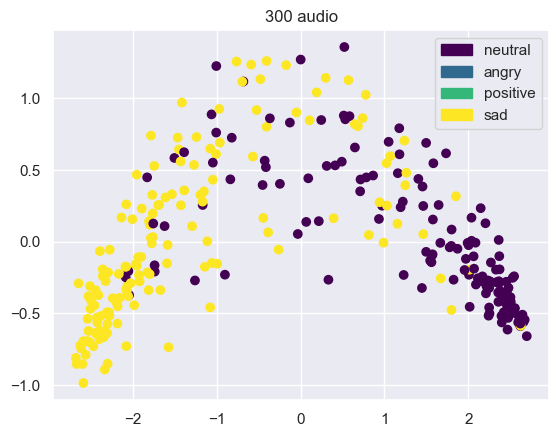

In [22]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

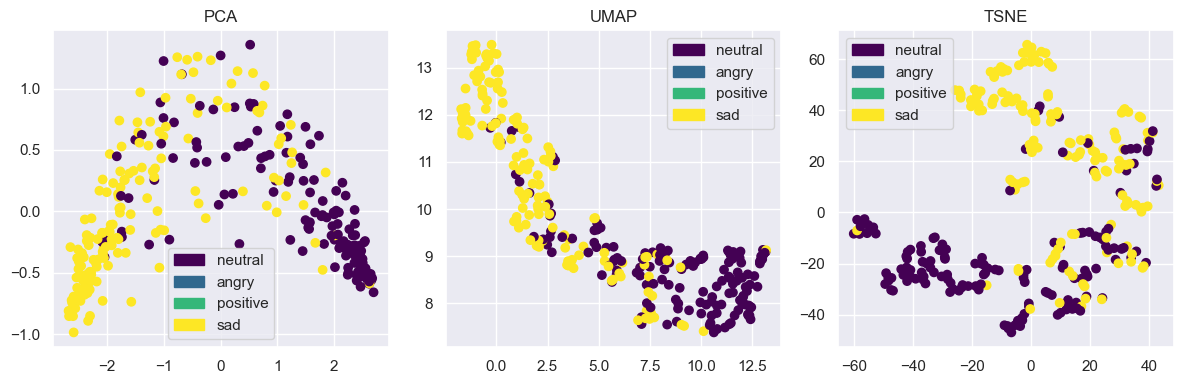

In [23]:
plot_2d_triple(data, labels)

-------------

### Тренировочный набор

In [14]:
n_samples = 5
df_reduce = train_df.groupby(['label']).head(n_samples).reset_index(drop=True)

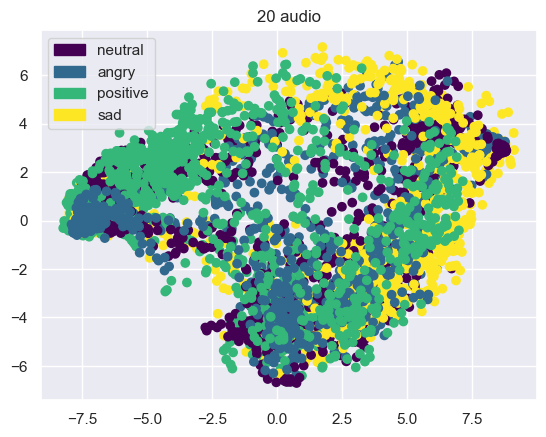

In [15]:
# custom-hubert-base-dusha-ft-triplets-m1-480tr-1al-cos
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

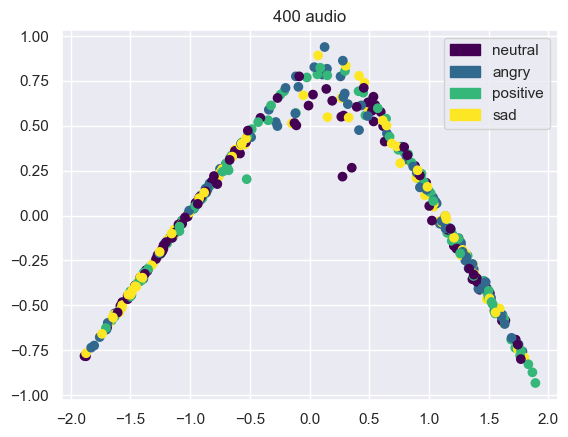

In [13]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

---------------

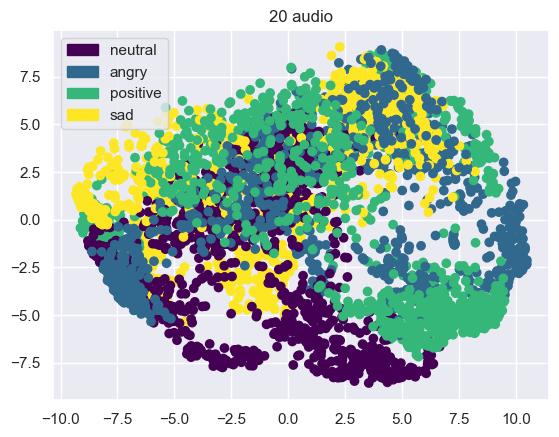

In [9]:
# custom-hubert-base-dusha-ft-triplets-m1-480tr-12l
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

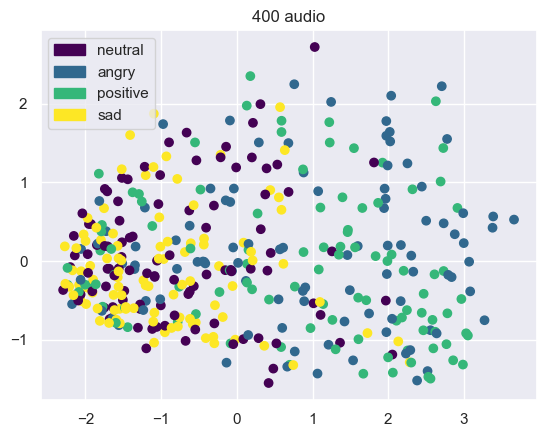

In [11]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

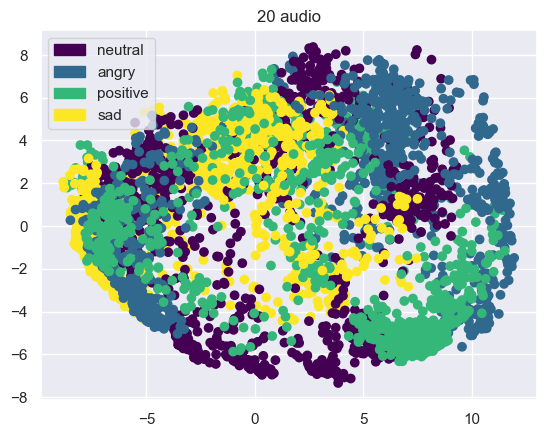

In [20]:
# custom-hubert-base-dusha-ft-triplets-m1-480tr-1al
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

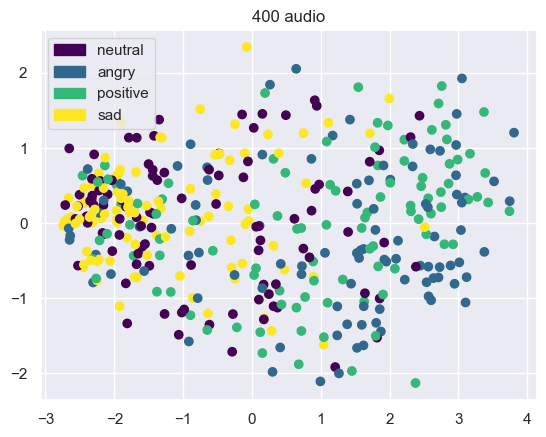

In [18]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

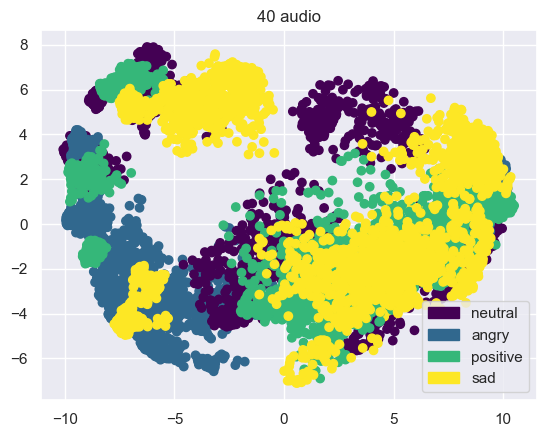

In [15]:
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

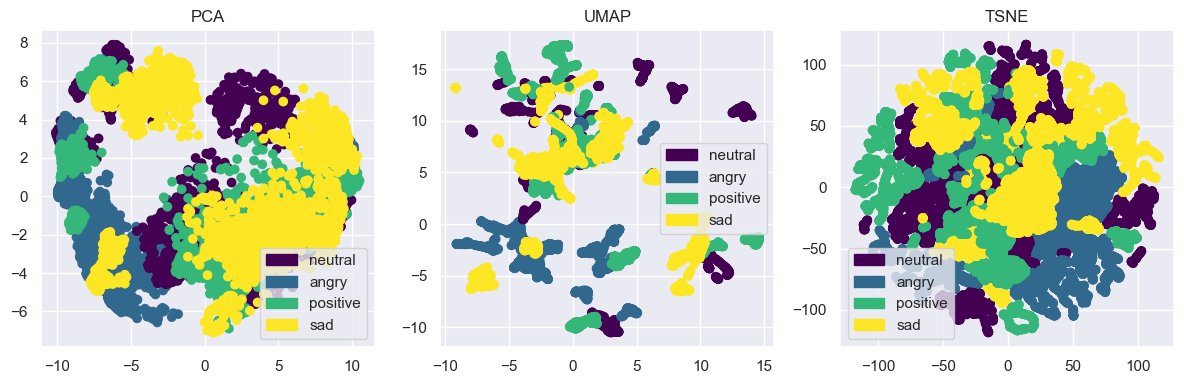

In [16]:
plot_2d_triple(data, labels)

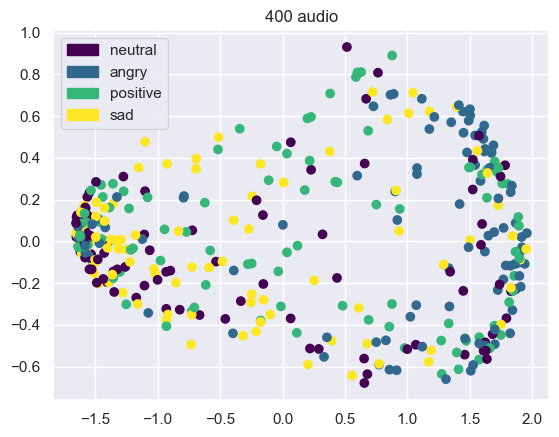

In [12]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

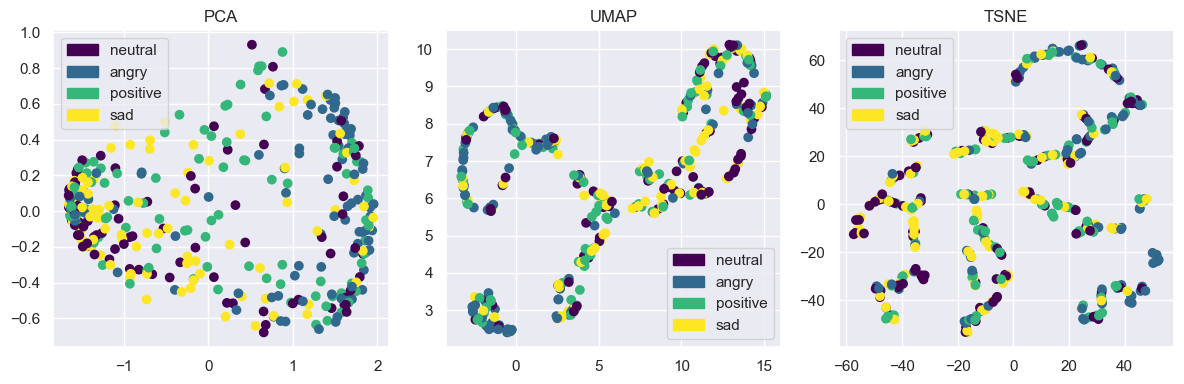

In [13]:
plot_2d_triple(data, labels)

### Тестовый набор

In [17]:
n_samples = 10
df_reduce = test_df.groupby(['emotion']).head(n_samples).reset_index(drop=True)

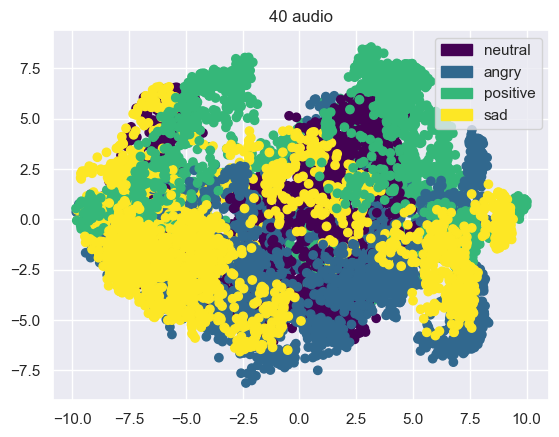

In [18]:
data, labels = get_last_hidden_state_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")

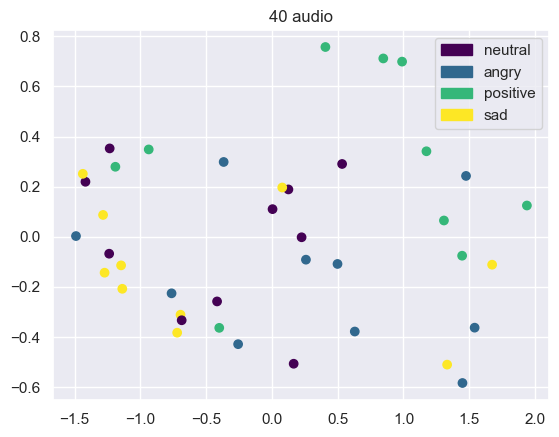

In [19]:
data, labels = get_embeddings_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 4} audio")